
# Titanic exploration: clean EDA and gradient boosting classifier optimized with Optuna
This notebook presents a complete machine learning workflow, from data preprocessing to final model selection, using clear exploratory data analysis and a high-accuracy Bayesian-optimized LGBM classifier.

### Topics:
- Data preprocessing
- Missing value imputation
- Feature engineering
- Data visualization
- Feature selection
- One-hot encoding
- Train-test split
- Model evaluation metrics
- Cross-validation
- Bayesian optimization with Optuna
- Feature importance analysis
- Performance comparison of different models
- Final model selection and retraining on the entire dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Disable chained assignment warning
pd.options.mode.chained_assignment = None 

# 1 Loading and Visualizing Data
Importing the dataset and creating various plots and charts to better understand the data and gain insights into its structure.

## 1.1 Loading data
Reading the dataset from a file or external source into a suitable data structure like a DataFrame for further processing and analysis.

In [2]:
train_data_file, test_data_file = '../input/titanic/train.csv', '../input/titanic/test.csv'
train_df = pd.read_csv(train_data_file, index_col=0)
test_df = pd.read_csv(test_data_file, index_col=0)

# Auxiliary data, a list of common British names from 1900.
british_name_list = pd.read_csv('../input/british-names/british_names.csv', names=['Name'])

In [3]:
train_df.iloc[60:65]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN
63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S
64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S
65,0,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C


In [4]:
test_df.iloc[0:5]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Observations:
- The dataset provides a comprehensive set of passenger information.
- The test data does not include the 'Survived' feature, which is the target variable for predictions.

### Description of dataset:

1. Survived (C): Indicates if the passenger survived or not [Key: 0 = No, 1 = Yes] - target variable
2. Pclass (C): Ticket class representing the passenger's socio-economic status [Key: 1 = First/Upper, 2 = Second/Middle, and 3 = Third/Lower]
3. Name (C): Passenger's name.
4. Sex (C): Passenger's gender [Key: male & female]
5. Age (N): Passenger's age in years, with a precision of 0.5 years.
6. SibSp (C): Number of siblings and spouses aboard.
7. Parch (C): Number of parents or children aboard the Titanic.
8. Ticket (C): Passenger's ticket number.
9. Fare (N): Cost of the passenger's ticket.
10. Cabin (C): Cabin number assigned to the passenger.
11. Embarked (C): Port of embarkation [Key: C=Cherbourg, Q=Queenstown, S=Southampton].

NOTE: (C) denotes a Categorical feature and (N) denotes a Numeric feature.

## 1.2 Basic information and intuitive analysis of our dataset
Gathering essential information about the dataset, such as the number of samples, features, data types, and identifying any potential correlations or relationships between variables.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Observations:
- We have records for 1309 passengers (891 from the training set and 418 from the test set), which is 58% of the 2224 passengers onboard the RMS Titanic.
- Out of the 2224 passengers, 1502 died and 722 survived (32% survival rate). However, we only have records for 342 of the 891 survivors in the training set.
- The **Name** field seems to follow a fixed format: [Last_Name, Salutation. (Other names etc.)].
- In the training dataset, there are 577 males and 314 females (70% male vs 30% female).
- **SibSp** ranges from 0-8 and **Parch** ranges from 0-6. There are 531 of the 891 passengers (approximately 60%) traveling alone (i.e., Parch = 0 and SibSp = 0).
- The **Ticket** column contains many duplicate values.
- **Fare** ranges from 0.0 to 512.3. Fifteen passengers have a 0.0 fare, all of whom are male, embarked at Southampton, and belong to different passenger classes. This suggests that 0.0 may have been used for missing fare values.
- The **Cabin** column has a large number of missing values (687 out of 891) and some rows have multiple cabins.
- **Embarkation** [C=Cherbourg (168), Q=Queenstown (77), S=Southampton (644)]. The majority of passengers boarded at Southampton.

### Intuitive analysis:
- **Survived**: This is our target variable.
- **Pclass**: Passengers in Pclass = 1 might have had a higher survival rate compared to those in Pclass = 3.
- **Sex**: Due to the "Women and Children first" policy, females may have had a higher survival rate than males.
- **Age**: Older passengers and children might have been prioritized during the evacuation, thus having a higher chance of survival.
- **SibSp**: Family members (siblings & spouses) may have been evacuated together, affecting the chances of survival.
- **Parch**: Families (parents & children) could have been loaded and evacuated together, influencing survival probability.
- **Fare**: Higher fares might indicate a higher class of travel and, potentially, a greater chance of survival (could be correlated with Pclass as well).
- **Embarked**: Examine if embarkation points have any impact on survival rates and their distribution across Pclass.

#### The following features may not directly contribute to the chance of survival but might contain relevant information:

- **Name** - Passenger names on the tickets. [NOTE: The title (e.g., Mr., Mrs., etc.) DOES seem useful for determining age. Since names are listed in a fixed format, we should be able to extract titles and analyze data further (e.g., checking if titles correspond to the correct sex and using them to estimate missing ages)]. However, names themselves do not appear to directly influence survival chances.
- **Ticket** - Passenger ticket numbers.
- **Cabin** - Passenger cabin numbers. A large portion of the data is missing, but we can investigate whether missing data is related to survival chances, as survivors were more likely to provide their information.




## 1.3 Exploratory data analysis
Examining the data through summary statistics, distributions, and visualizations to identify patterns, trends, and potential issues.

### Survival by sex
Let's investigate the relationship between a passenger's gender and their survival rate. It's possible that one gender had a higher likelihood of survival due to factors like evacuation prioritization.

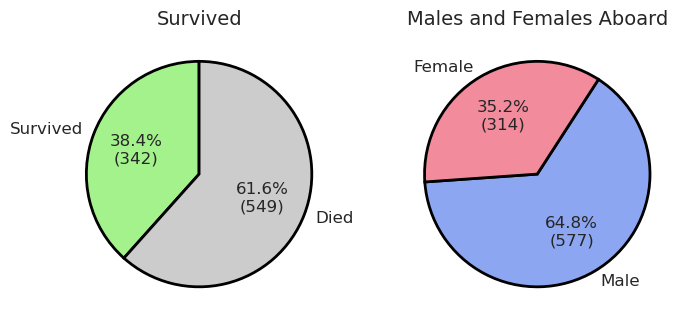

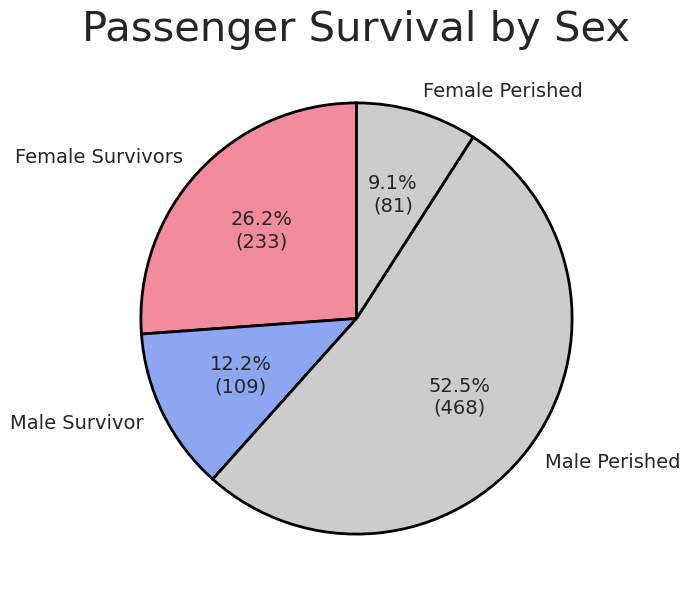

In [7]:
n_passengers = len(train_df)
n_passengers_survived = len(train_df.loc[train_df.Survived == 1])
n_passengers_died = n_passengers - n_passengers_survived

n_male_passengers = len(train_df.loc[train_df.Sex == "male"])
n_female_passengers = len(train_df.loc[train_df.Sex == "female"])

n_male_survived = len(train_df.loc[(train_df.Sex == "male") & (train_df.Survived == 1)])
n_male_died = n_male_passengers - n_male_survived

n_female_survived = len(train_df.loc[(train_df.Sex == "female") & (train_df.Survived == 1)])
n_female_died = n_female_passengers - n_female_survived


# Tweaks for Seaborn
sns.set_style('whitegrid')

# Pie plot styling
wedgeprops = {"edgecolor":"black",'linewidth': 2, 'antialiased': True}

# Colors to be used in this project
f_color = "#f28c9d"
m_color = "#8ca6f2"
s_color = "#a4f28c"
d_color = "#cccccc"
g_color = '#f2d98c'


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 10))

data = [n_passengers_survived, n_passengers_died]
keys = ["Survived", "Died"]
colors = [s_color, d_color]

ax[0].pie(data,
        labels=keys, 
        colors=colors,
        startangle=90,
        wedgeprops=wedgeprops,
        textprops={'fontsize': 12},
        autopct=lambda p:f'{p:.1f}%\n({p*sum(data)/100 :.0f})')

data = [n_male_passengers, n_female_passengers]
keys = ["Male", "Female"]
colors = [m_color, f_color]

ax[0].set_title("Survived", fontdict = {'fontsize' : 14})

ax[1].pie(data,
        labels=keys, 
        colors=colors,
        startangle=184,
        wedgeprops=wedgeprops,
        textprops={'fontsize': 12},
        autopct=lambda p:f'{p:.1f}%\n({p*sum(data)/100 :.0f})')

ax[1].set_title("Males and Females Aboard", fontdict = {'fontsize' : 14})
plt.show()

data = [n_female_survived, n_male_survived, n_male_died, n_female_died]
keys = ["Female Survivors", "Male Survivor", "Male Perished", "Female Perished"]
colors = [f_color, m_color, d_color, d_color]

fig, ax = plt.subplots(figsize=(8,7))
plt.pie(data, 
        labels=keys, 
        colors=colors,
        startangle=90,
        wedgeprops=wedgeprops,
        textprops={'fontsize': 14},
        autopct=lambda p:f'{p:.1f}%\n({p*sum(data)/100 :.0f})')

plt.title("Passenger Survival by Sex", fontdict = {'fontsize' : 30})
plt.show()

#### Observations:
- Most passengers onboard were male.
- 549 passengers did not survive.
- 342 passengers did survive.
- Only 44% of passengers survived.


- 74% of women survived.
- Only 19% of men survived.
- 83% of deaths were men.

### Survival by passenger class
Examining the connection between a passenger's ticket class and their chances of survival. Higher-class passengers may have had better access to lifeboats or other survival resources.

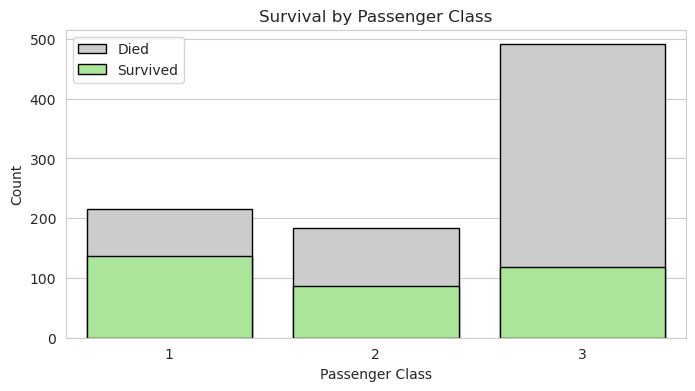

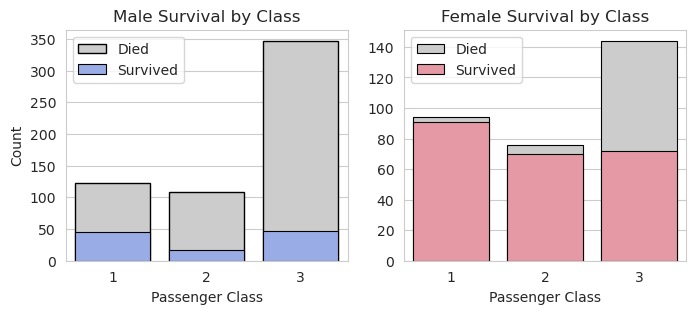

In [8]:
f, ax = plt.subplots(figsize=(8, 4))

sns.countplot(data=train_df, 
              x='Pclass', 
              ax=ax, 
              edgecolor='black',
              linewidth=1,
              color=d_color)

sns.countplot(data=train_df.loc[train_df.Survived == 1], 
              x='Pclass', 
              edgecolor='black',
              linewidth=1,
              ax=ax, 
              color=s_color)

ax.set(xlabel="Passenger Class", ylabel="Count")
ax.set_title('Survival by Passenger Class')
plt.legend(['Died', 'Survived'], loc='upper left')

plt.show()


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))

sns.countplot(data=train_df.loc[train_df.Sex == 'male'], 
              x='Pclass', 
              edgecolor='black',
              linewidth=1,
              ax=ax[0], 
              color=d_color)

sns.countplot(data=train_df.loc[(train_df.Sex == 'male') & (train_df.Survived == 1)],
              x='Pclass', 
              edgecolor='black',
              linewidth=0.8,
              ax=ax[0], 
              color=m_color)

ax[0].set(xlabel="Passenger Class", ylabel="Count")
ax[0].set_title('Male Survival by Class')
ax[0].legend(['Died', 'Survived'], loc='upper left')


sns.countplot(data=train_df.loc[train_df.Sex == 'female'], 
              x='Pclass', 
              edgecolor='black',
              linewidth=0.8,
              ax=ax[1], 
              color=d_color)

sns.countplot(data=train_df.loc[(train_df.Sex == 'female') & (train_df.Survived == 1)], 
              x='Pclass', 
              edgecolor='black',
              linewidth=0.8,
              ax=ax[1], 
              color=f_color)
ax[1].set(xlabel="Passenger Class", ylabel="")
ax[1].set_title('Female Survival by Class')
ax[1].legend(['Died', 'Survived'], loc='upper left')

plt.show()

#### Observations:
- First class passengers were significantly more likely to survive.
- Almost all female first and second class passengers survived.
- Class has less influence on survival for men than it does for women.


- 63% of first class passengers survived.
- 47% of second class passengers survived.
- 24% of third class passengers survived.

### Survival by age
Exploring the association between age and survival, as certain age groups may have been more vulnerable or prioritized during the evacuation process.

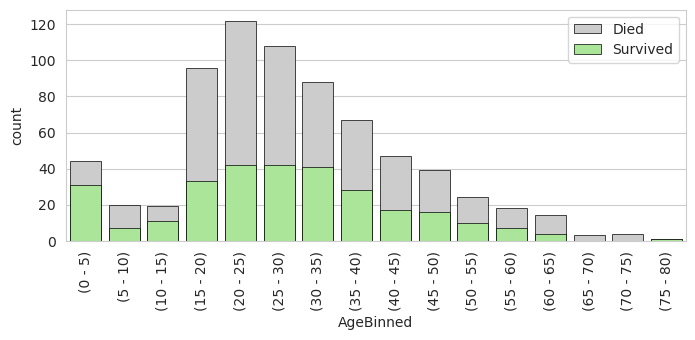

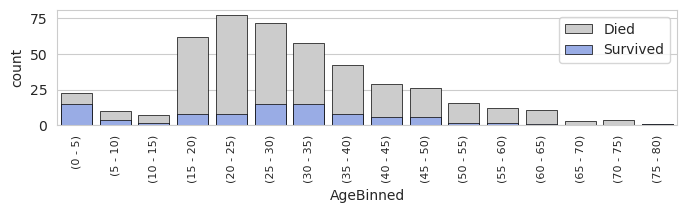

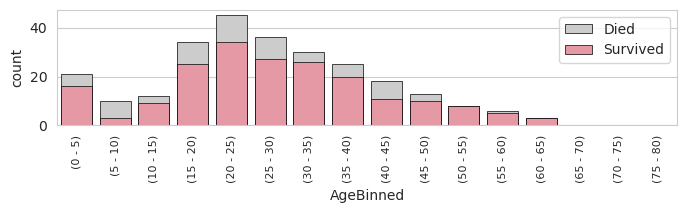

In [9]:
# Specify our bin boundaries, 15 bins
bins = [*range(0, 85, 5)]

def reformat_bins(df, col):
    return df[col].apply(lambda x: f"({int(x.left)} - {int(x.right)})")
    
age_binned = pd.DataFrame(pd.cut(train_df.Age, bins=bins, include_lowest=True))
train_df['AgeBinned'] = reformat_bins(age_binned, 'Age')

fig, ax = plt.subplots(figsize=(8,3))


sns.countplot(data=train_df, 
              x='AgeBinned',
              edgecolor='black',
              linewidth=0.5,
              ax=ax, 
              color=d_color)

sns.countplot(data=train_df.loc[train_df.Survived == 1], 
              x='AgeBinned', 
              edgecolor='black',
              linewidth=0.5,
              ax=ax, 
              color=s_color)

ax.legend(['Died', 'Survived'], loc='upper right')
ax.tick_params(axis='x', rotation=90, labelsize=10)

plt.show()



fig, ax = plt.subplots(figsize=(8,1.5))

sns.countplot(data=train_df.loc[train_df.Sex == 'male'], 
              x='AgeBinned', 
              edgecolor='black',
              linewidth=0.5,
              ax=ax, 
              color=d_color)

sns.countplot(data=train_df.loc[(train_df.Sex == 'male') & (train_df.Survived == 1)], 
              x='AgeBinned', 
              edgecolor='black',
              linewidth=0.5,
              ax=ax, 
              color=m_color)

ax.legend(['Died', 'Survived'], loc='upper right')
ax.tick_params(axis='x', rotation=90, labelsize=8)

plt.show()

fig, ax = plt.subplots(figsize=(8,1.5))

sns.countplot(data=train_df.loc[train_df.Sex == 'female'], 
              x='AgeBinned', 
              edgecolor='black',
              linewidth=0.5,
              ax=ax, 
              color=d_color)

sns.countplot(data=train_df.loc[(train_df.Sex == 'female') & (train_df.Survived == 1)], 
              x='AgeBinned', 
              edgecolor='black',
              linewidth=0.5,
              ax=ax, 
              color=f_color)

ax.legend(['Died', 'Survived'], loc='upper right')
ax.tick_params(axis='x', rotation=90, labelsize=8)

plt.show()

#### Observations:
- Children under 15 have a greater chance of surviving.
- Men over 50 have almost no chance of surviving.
- Women over 50 are almost certain to survive.
- Ages 15-50 don't appear to yield much information.

### Survival by presence of family
Analyzing the impact of having family members onboard on a passenger's survival rate. Traveling with family could influence the ability to secure lifeboat spots or navigate the chaotic situation.

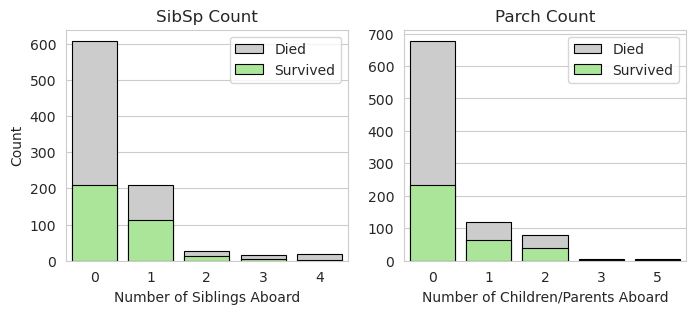

In [10]:
f, ax = plt.subplots(nrows=1, ncols=2,figsize=(8, 3))

sns.countplot(data=train_df, 
              x='SibSp', 
              edgecolor='black',
              linewidth=0.8,
              ax=ax[0], 
              color=d_color)

sns.countplot(data=train_df.loc[train_df.Survived == 1], 
              x='SibSp', 
              edgecolor='black',
              linewidth=0.8,
              ax=ax[0], 
              color=s_color)

ax[0].legend(['Died', 'Survived'], loc='upper right')
ax[0].set(xlabel="Number of Siblings Aboard", ylabel="Count")
ax[0].set_title('SibSp Count')

sns.countplot(data=train_df, 
              x='Parch', 
              edgecolor='black',
              linewidth=0.8,
              ax=ax[1], 
              color=d_color)

sns.countplot(data=train_df.loc[train_df.Survived == 1], 
              x='Parch', 
              edgecolor='black',
              linewidth=0.8,
              ax=ax[1], 
              color=s_color)

ax[1].legend(['Died', 'Survived'], loc='upper right')
ax[1].set(xlabel="Number of Children/Parents Aboard", ylabel="")
ax[1].set_title('Parch Count')

plt.show()


#### Observations:
- It appears having some family aboard slightly increases chance of survival.

#### Feature engineering:
We will replace these features with a single numerical feature 'Fob' (family on board) which will contain a 0 for people with no family onboard, 1 for people with 1 to 3, then 2 for people with 4 or more. We will one-hot encode this as a categorical variable later.

In [11]:
train_df['Fob'] = train_df['SibSp'] + train_df['Parch']
test_df['Fob'] = test_df['SibSp'] + test_df['Parch']

train_df[['Survived','SibSp','Parch','Fob']].head(8)

,Survived,SibSp,Parch,Fob
PassengerId,,,,
1,0,1,0,1
2,1,1,0,1
3,1,0,0,0
4,1,1,0,1
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,3,1,4


In [12]:
familyOnBoard = lambda row : 0 if (row.Fob<1) else (1 if row.Fob<4 else 2) 

train_df['Fob'] = train_df.apply(familyOnBoard, axis=1)
test_df['Fob'] = test_df.apply(familyOnBoard, axis=1)

train_df[['Survived','SibSp','Parch','Fob']].head(8)

,Survived,SibSp,Parch,Fob
PassengerId,,,,
1,0,1,0,1
2,1,1,0,1
3,1,0,0,0
4,1,1,0,1
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,3,1,2


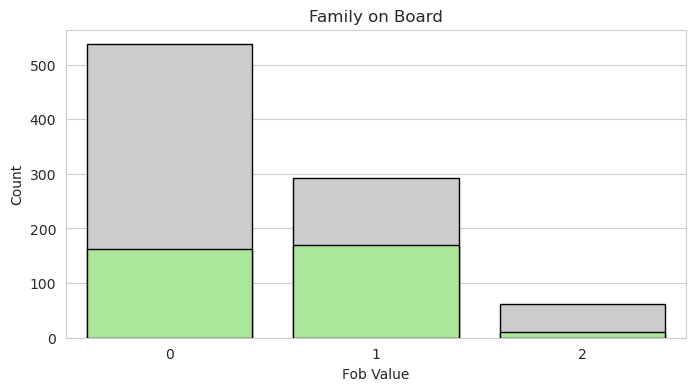

In [13]:
f, ax = plt.subplots(figsize=(8, 4))

sns.countplot(data=train_df, 
              x='Fob', 
              edgecolor='black',
              linewidth=1,
              ax=ax, 
              color=d_color)

sns.countplot(data=train_df.loc[train_df.Survived == 1], 
              x='Fob', 
              edgecolor='black',
              linewidth=1,
              ax=ax, 
              color=s_color)

ax.set(xlabel="Fob Value", ylabel="Count")
ax.set_title('Family on Board')

plt.show()

#### Observations:
- Having many or no family members on board seems to negatively affect survival chance, although not significantly.

### Survival by title in name
Investigating the link between a passenger's title (e.g., Mr., Mrs., Miss, Master) and their survival chances. Titles might indicate social standing, marital status, or age, which could have affected survival outcomes.

In [14]:
# Let's use regex to extract the title from each passenger's name string
# i.e. (Mr. Miss. Mrs. etc.) and save it as a new feature.
train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

train_df[['Name', 'Title', 'Sex', 'Age']].head(10)

,Name,Title,Sex,Age
PassengerId,,,,
1,"Braund, Mr. Owen Harris",Mr,male,22.0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,female,38.0
3,"Heikkinen, Miss. Laina",Miss,female,26.0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,female,35.0
5,"Allen, Mr. William Henry",Mr,male,35.0
6,"Moran, Mr. James",Mr,male,NaN
7,"McCarthy, Mr. Timothy J",Mr,male,54.0
8,"Palsson, Master. Gosta Leonard",Master,male,2.0
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Mrs,female,27.0


In [15]:
# Let's replace the titles with only the simple ones.
male_titles = ['Capt', 'Col', 'Don','Jonkheer','Major','Rev','Sir']
miss_titles = ['Mlle','Ms','Mme'] # Young female titles
female_titles = ['Countess','Dona','Lady'] # Other female titles

for df in [train_df, test_df]:
    df['Title'] = df['Title'].replace(miss_titles, 'Miss')
    df['Title'] = df['Title'].replace(female_titles, 'Mrs')
    df['Title'] = df['Title'].replace(male_titles, 'Mr')
    male_dr_filter = (df.Title == 'Dr') & (df.Sex == 'male')
    female_dr_filter = (df.Title == 'Dr') & (df.Sex == 'female')
    df.loc[male_dr_filter, ['Title']] = 'Mr'
    df.loc[female_dr_filter, ['Title']] = 'Mrs'

# Let's show this new feature in a DataFrame.
# We're going to add columns that help us see the counts and survival chances
# for each title.
combo_df = pd.concat((train_df,test_df))
pd.concat([pd.crosstab(combo_df['Title'], combo_df['Sex']),
          pd.crosstab(train_df['Title'], train_df['Survived']),
          train_df[['Title', 'Survived']].groupby(['Title']).mean().sort_values(by='Survived', ascending=False)],
          axis=1)

,female,male,0,1,Survived
Title,,,,,
Master,0,61,17,23,0.575000
Miss,265,0,55,131,0.704301
Mr,0,782,451,86,0.160149
Mrs,201,0,26,102,0.796875


#### Observations:
- The likelihood of survival for each title group is as follows: women have the highest chance, followed by girls, then boys, and finally men with the lowest probability.

### Survival by presence of cabin number
Let's explore if there's a link between the presence of a cabin number and survival. It's possible that passengers with cabin numbers only have them because they survived and that missing data indicates a passenger died.

In [16]:
train_df['Cabin'] = train_df['Cabin'].apply(lambda x: 1 if not pd.isnull(x) else 0)
test_df['Cabin'] = test_df['Cabin'].apply(lambda x: 1 if not pd.isnull(x) else 0)

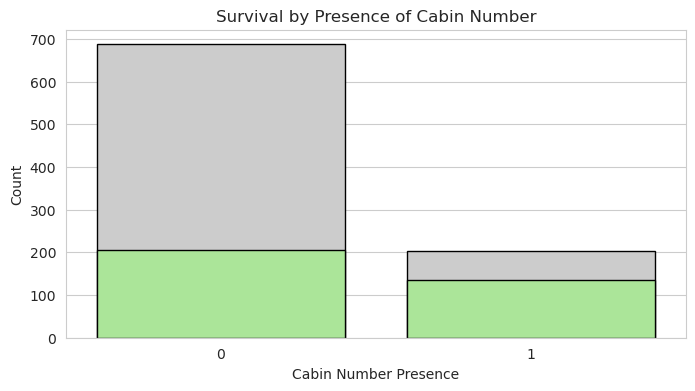

In [17]:
f, ax = plt.subplots(figsize=(8, 4))

sns.countplot(data=train_df, 
              x='Cabin', 
              edgecolor='black',
              linewidth=1,
              ax=ax, 
              color=d_color)

sns.countplot(data=train_df.loc[train_df.Survived == 1], 
              x='Cabin', 
              edgecolor='black',
              linewidth=1,
              ax=ax,
              color=s_color)

ax.set(xlabel="Cabin Number Presence", ylabel="Count")
ax.set_title('Survival by Presence of Cabin Number')

plt.show()

#### Observations:
- Presence of a cabin number seems to strongly indicate that a passenger survived. 
- An absence of a cabin number seems to have little to no effect.

### Survival by British name

A list of approx 850 British first names from 1900 was found on the internet and imported, alongside a small database of popular current British family names, with names of foreign origin manually removed.

This feature is used as a heuristic for 'English speaking' or 'Immigrant Status', which may influence survival.

Sources: 

https://www.britishbabynames.com/blog/2012/08/top-200-most-popular-names-in-england-and-wales-1900.html

https://forebears.io/england/surnames


In [18]:
# Let's consider whether passengers have British names or not, and whether this influences survival

britishName = lambda x: 1 if any(i in x for i in british_name_list['Name']) else 0 

for df in [train_df, test_df]:
    df['BritishName'] = df['Name'].apply(britishName)
    
pd.concat([pd.crosstab(train_df['BritishName'], train_df['Survived']),
          train_df[['BritishName', 'Survived']].groupby(['BritishName']).mean().sort_values(by='Survived', ascending=False)],
          axis=1)

,0,1,Survived
BritishName,,,
0,165,65,0.282609
1,384,277,0.419062


#### Observations:
- It appears that having a British name increases chance of survival.
- 74% of people aboard have a relatively common British name. 

### Survival by surviving family members
We will create a new feature that defaults to 0.5.
If it can be determined that the passenger had family aboard who died, this value will be changed to 0.
If it can be determined that the passenger had family aboard who survived, this value will be changed to 0.5.

We will determine this by looking at last name and fare, as well as ticket number.

In [19]:
data_df = train_df.append(test_df)
data_df['PassengerId'] = data_df.index

# Group people by their last name and fare.
# People with the same last name and fare are likely to be family.
data_df['Last_Name'] = data_df['Name'].apply(lambda x: x.split(",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['FamilySurvival'] = DEFAULT_SURVIVAL_VALUE
 
def update_family_survival(grp_df, data_df):
    """This function takes in a group DataFrame (grp_df) 
    and the main DataFrame (data_df) and updates the 'FamilySurvival' 
    values based on the given group. 
    We call this function for both 'Last_Name'-'Fare' and 'Ticket' groups."""
    for ind, row in grp_df.iterrows():
        smax = grp_df.drop(ind)['Survived'].max()
        smin = grp_df.drop(ind)['Survived'].min()
        passID = row['PassengerId']
        if smax == 1.0:
            data_df.loc[data_df['PassengerId'] == passID, 'FamilySurvival'] = 1
        elif smin == 0.0:
            data_df.loc[data_df['PassengerId'] == passID, 'FamilySurvival'] = 0
    return data_df

for grp, grp_df in data_df.groupby(['Last_Name', 'Fare']):
    if len(grp_df) != 1:
        data_df = update_family_survival(grp_df, data_df)

for _, grp_df in data_df.groupby('Ticket'):
    if len(grp_df) != 1:
        data_df = update_family_survival(grp_df, data_df)

data_df = data_df.drop(['PassengerId'], axis=1)
data_df = data_df.drop(['Last_Name'], axis=1)

n_training_samples = len(train_df)
train_df = data_df.iloc[:n_training_samples]
test_df = data_df.iloc[n_training_samples:]
test_df = test_df.drop(['Survived'], axis=1)

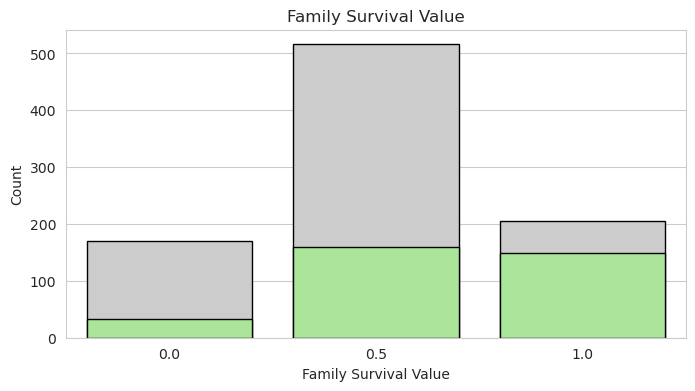

In [20]:
f, ax = plt.subplots(figsize=(8, 4))

sns.countplot(data=train_df, 
              x='FamilySurvival', 
              edgecolor='black',
              linewidth=1,
              ax=ax, 
              color=d_color)

sns.countplot(data=train_df.loc[train_df.Survived == 1], 
              x='FamilySurvival',
              edgecolor='black',
              linewidth=1,
              ax=ax, 
              color=s_color)

ax.set(xlabel="Family Survival Value", ylabel="Count")
ax.set_title('Family Survival Value')

plt.show()

#### Observations:
- Passengers with family aboard who died were also unlikey to survive.
- Passengers with family aboard who survived were also likely to survive.

# 2 Data Cleaning

In this section we will handle missing data to prepare data for processing.

In [21]:
# Quickly check for nulls across both DataFrames.
pd.concat((train_df,test_df)).isnull().sum()

Survived          418
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin               0
Embarked            2
AgeBinned         595
Fob                 0
Title               0
BritishName         0
FamilySurvival      0
dtype: int64

#### Observations:

- We have NULL values in Age, Fare, and Embarked.
- Embarked we will replace missing values with the mode.
- Fare we will first replace NULL values with 0, then replace 0 values with the mean fare by Pclass.
- Age we will replace missing values with the mean age by Title.

## 2.1 Replacing nulls
Filling missing values with appropriate methods such as mean, median, or mode imputation, or using advanced techniques like KNN imputation.

### Embarked
Replace missing values in this feature with the mode (ie the most common destination).

In [22]:
print(pd.concat((train_df['Embarked'],test_df['Embarked'])).isnull().sum(), "missing values before,")

# Embarked - replace missing values (2 rows) with most common value (i.e. mode()) of Embarked field
train_df.Embarked.fillna(train_df.Embarked.mode().copy()[0], inplace=True)
test_df.Embarked.fillna(test_df.Embarked.mode().copy()[0], inplace=True)

print(pd.concat((train_df['Embarked'],test_df['Embarked'])).isnull().sum(), "missing values after.")

2 missing values before,
0 missing values after.


### Fare
Replace the 0 values with the mean fare by passenger class.

In [23]:
print(sum(pd.concat((train_df['Fare'],test_df['Fare']))<=0), "missing values before,")

# First replace all missing values with 0.0
values = {'Fare': 0.0} 

train_df.fillna(value=values,inplace=True)
test_df.fillna(value=values,inplace=True)
    
# Create fare lookup tables for train_df & test_df which we will later use to replace zero values.
fare_table_train = (train_df.loc[train_df.Fare != 0.0][['Pclass','Fare']].groupby(['Pclass']).median()).copy()
fare_table_test = (test_df.loc[test_df.Fare != 0.0][['Pclass','Fare']].groupby(['Pclass']).median()).copy()

# Replace 0 values with table values
for df, fare_table in zip([train_df, test_df],[fare_table_train, fare_table_test]):
    for cls in np.unique(df.Pclass):
        df.loc[((df.Fare <= 0.0) & (df.Pclass == cls)), ['Fare']] = fare_table.loc[cls][0].copy()

print(pd.concat((train_df['Fare'],test_df['Fare'])).isnull().sum(), "missing values after.")

17 missing values before,
0 missing values after.


### Age
Replace age with mean age by title, which we determined earlier.

In [24]:
print(pd.concat((train_df['Age'],test_df['Age'])).isnull().sum(), "missing values before,")

# Find mean age by Title, for rows where age is not Null
age_lookup_train = (train_df.loc[(train_df['Age'] != 0.0), ['Age', 'Title']].groupby('Title').mean()).copy()
age_lookup_test = (test_df.loc[(test_df['Age'] != 0.0), ['Age', 'Title']].groupby('Title').mean()).copy()

for df, age_lookup in zip([train_df, test_df],[age_lookup_train, age_lookup_test]):
    for title in ['Master','Miss','Mr','Mrs']:
        df.loc[((df['Title'] == title) & (df['Age'].isnull())),['Age']] = age_lookup.loc[title][0]

print(pd.concat((train_df['Age'],test_df['Age'])).isnull().sum(), "missing values after.")

263 missing values before,
0 missing values after.


In [25]:
# Quickly check for nulls across both DataFrames.
pd.concat((train_df,test_df)).isnull().sum()

Survived          418
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin               0
Embarked            0
AgeBinned         595
Fob                 0
Title               0
BritishName         0
FamilySurvival      0
dtype: int64

# 3 Data Preprocessing

We will select the following features for our models:

**Survived, Pclass, Title, Age, Fare, Embarked, Fob, BritishName**

We will drop the following features for our models:

**Sex, SibSp, Parch, Name, Ticket, Cabin**

#### Justifications for dropping features:
- Dropping Sex as it's contained within Title.
- Dropping Parch and SibSp as they are contained within Fob.

## 3.1 Transforming and feature engineering
Applying transformations, generating new features, and refining existing ones to improve model performance and capture relevant patterns in the data.
### Fare log transform
The Fare feature is heavily positively skewed with many outliers and may benefit from outlier rectification and a log transform. 


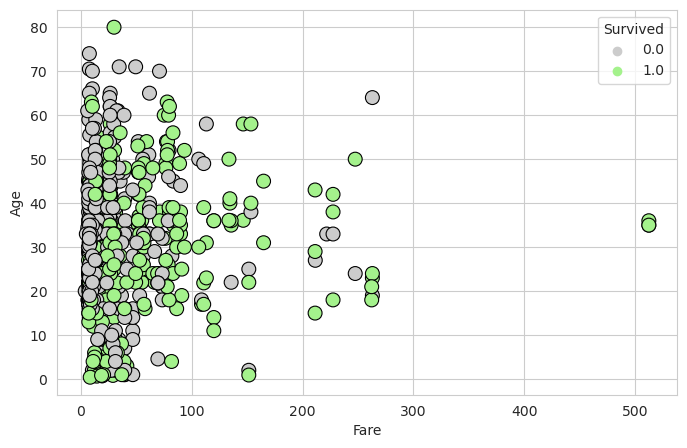

In [26]:
# Let's explore the fare data.
f, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=train_df, 
                x='Fare', 
                y='Age', 
                hue='Survived', 
                palette=[d_color, s_color],
                s=100,
                edgecolor="black",
                linewidth=0.8)
plt.show()


#### Observations:
- We have some clear outliers which will interfere with training.
- Fare values over approximately 150 will be scaled down.
- Looking at these data it's not clear what effect Fare has on Survival.

In [27]:
# Check current correlation of Fare with Survival.
print("Correlation between fare and survival before transform:\n",
      train_df['Fare'].corr(train_df['Survived']))

Correlation between fare and survival before transform:
 0.25038343117495154


In [28]:
# Function to scale down very large values.
scaleDown = lambda x: x*0.25 + 75 

# Clips excessively large values, scales down very large values, then log transform the whole column.
for df in [train_df, test_df]:
    df['Fare'].where(df['Fare'] < 300, 300, inplace=True) # Note that 'where' replaces values where the condition is false
    df['Fare'].where(test_df['Fare'] < 100, scaleDown, inplace=True)
    df['Fare'] = np.log10(df['Fare'])

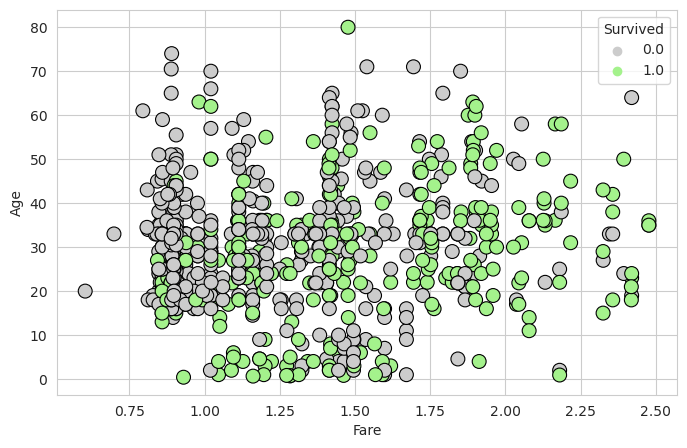

In [29]:
# Let's explore the fare data.
f, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=train_df, 
                x='Fare', 
                y='Age', 
                hue='Survived', 
                palette=[d_color, s_color],
                s=100,
                edgecolor="black",
                linewidth=0.8)
plt.show()

In [30]:
# Observe an increased correlation between feature and prediction.
print("Correlation between fare and survival after transform:\n", 
      train_df['Fare'].corr(train_df['Survived']))

Correlation between fare and survival after transform:
 0.31780002151277936


### Binning ages
To better capture the relationship between age and survival chances, we will create two categorical features, 'Young' and 'Old'. This is because age has a non-linear impact on survival: both low and high ages are associated with higher survival rates, while middle-aged individuals experience lower survival rates. By creating these two features, we aim to account for the variance in survival rates among these three distinct age groups.

In [31]:
train_df['Old'] = (train_df['Age'] > 50).astype(int)
test_df['Old'] = (test_df['Age'] > 50).astype(int)

train_df['Young'] = (train_df['Age'] < 15).astype(int)
test_df['Young'] = (test_df['Age'] < 15).astype(int)

## 3.2 Encoding categorical data
Converting categorical variables into numerical values using techniques like one-hot encoding and ordinal encoding.

### Title
One-hot encode Title feature by first ordinally encoding it, then one-hot encoding it.

In [32]:
# Label encode the categorical features Title and Embarked
train_df['Title'] = train_df['Title'].map( {'Miss': 4, 'Mrs': 3, 'Master': 2, 'Mr': 1} ).astype(int)
test_df['Title'] = test_df['Title'].map( {'Miss': 4, 'Mrs': 3, 'Master': 2, 'Mr': 1} ).astype(int)

# Title, Fob needs to be One-hot-encoded as well. We'll use pandas.get_dummies()
train_df = pd.get_dummies(train_df,columns=['Title', 'Fob'], drop_first=True)
test_df = pd.get_dummies(test_df,columns=['Title', 'Fob'], drop_first=True)

## 3.4 Creating testing and training data
Splitting the dataset into separate training and testing sets for model training and evaluation.

In [33]:
test_features = ['Pclass', 'Fare', 'Age', 'Old', 'Young', 'Cabin', 
                 'BritishName', 'FamilySurvival','Title_2', 'Title_3', 
                 'Title_4', 'Fob_1', 'Fob_2']
train_features = test_features.copy()
train_features.append('Survived')

train_df = train_df[train_features]
test_df = test_df[test_features]

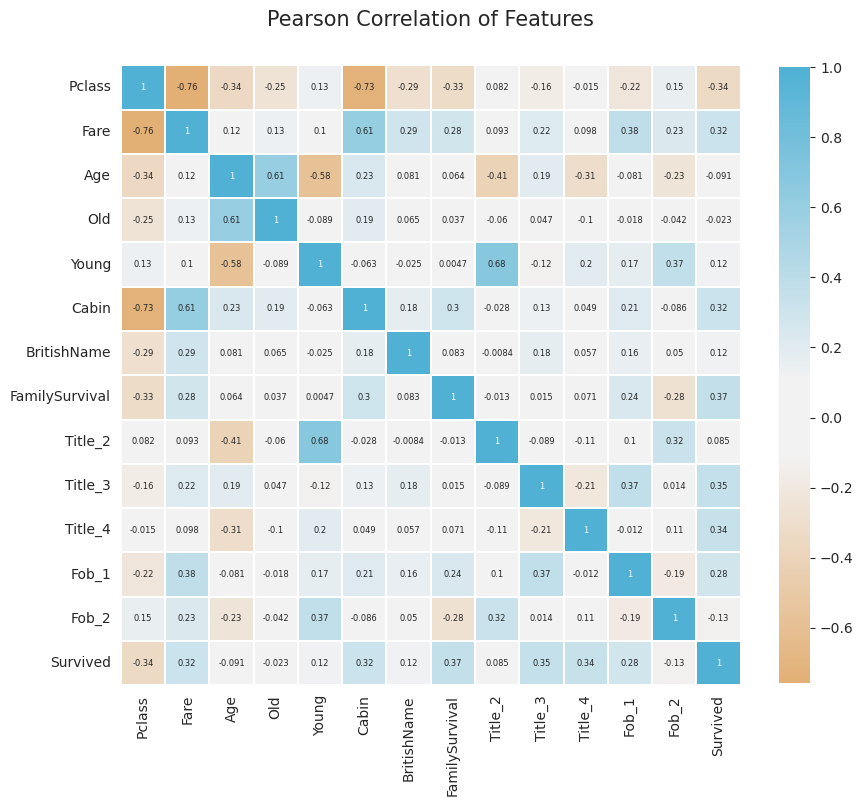

In [34]:
f, ax = plt.subplots(figsize = (10, 10))
colormap = sns.diverging_palette(h_neg=45, h_pos=225, s=81, l=68, sep=30, center='light', as_cmap=True)

sns.heatmap(
    train_df.corr('pearson'), 
    cmap=colormap,
    square=True, 
    center=0,
    cbar_kws={'shrink': .8}, 
    ax=ax,
    annot=True, 
    linewidths=0.1, vmax=1.0, linecolor='white',
    annot_kws={'fontsize': 6}
)

plt.title('Pearson Correlation of Features', y=1.05, size=15)
plt.show()

# 4 Finalizing Features
Selecting the most important features and discarding redundant or irrelevant ones to optimize model performance.

## 4.1 Setting final training and testing data
Preparing the final training and testing datasets with selected features and any necessary preprocessing steps.

In [35]:
target_col = train_df.columns.values[-1]
feature_cols = train_df.columns.values[:-1]
num_cols = ['Pclass','Fare', 'Age', 'FamilySurvival']

X_train, X_test = train_df[feature_cols], test_df[feature_cols]
y_train = train_df[target_col] 

X_train.head()

,Pclass,Fare,Age,Old,Young,Cabin,BritishName,FamilySurvival,Title_2,Title_3,Title_4,Fob_1,Fob_2
PassengerId,,,,,,,,,,,,,
1,3,0.860338,22.0,0,0,0,1,0.5,0,0,0,1,0
2,1,1.852988,38.0,0,0,1,1,0.5,0,1,0,1,0
3,3,0.898999,26.0,0,0,0,0,0.5,0,0,1,0,0
4,1,1.725095,35.0,0,0,1,1,0.0,0,1,0,1,0
5,3,0.905796,35.0,0,0,0,1,0.5,0,0,0,0,0


## 4.2 Scaling data
Standardizing or normalizing the features to ensure consistent scale and improve the performance of distance-based algorithms and gradient descent optimization.

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num_cols])

X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_train[num_cols] = X_train_scaled

X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)
X_test[num_cols] = X_test_scaled

X_train.head()

,Pclass,Fare,Age,Old,Young,Cabin,BritishName,FamilySurvival,Title_2,Title_3,Title_4,Fob_1,Fob_2
PassengerId,,,,,,,,,,,,,
1,0.827377,-1.036005,-0.589858,0,0,0,1,-0.060661,0,0,0,1,0
2,-1.566107,1.425972,0.614831,0,0,1,1,-0.060661,0,1,0,1,0
3,0.827377,-0.940117,-0.288686,0,0,0,0,-0.060661,0,0,1,0,0
4,-1.566107,1.108770,0.388952,0,0,1,1,-1.604923,0,1,0,1,0
5,0.827377,-0.923260,0.388952,0,0,0,1,-0.060661,0,0,0,0,0


## 4.3 Data type optimization
In this section, we will optimize our data types to improve computational efficiency. 

We will convert all one-hot encoded features to the uint8 data type, and numerical features to float32. This optimization reduces memory usage and computational time, as the extra precision is not required.

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pclass          891 non-null    float64
 1   Fare            891 non-null    float64
 2   Age             891 non-null    float64
 3   Old             891 non-null    int64  
 4   Young           891 non-null    int64  
 5   Cabin           891 non-null    int64  
 6   BritishName     891 non-null    int64  
 7   FamilySurvival  891 non-null    float64
 8   Title_2         891 non-null    uint8  
 9   Title_3         891 non-null    uint8  
 10  Title_4         891 non-null    uint8  
 11  Fob_1           891 non-null    uint8  
 12  Fob_2           891 non-null    uint8  
dtypes: float64(4), int64(4), uint8(5)
memory usage: 99.3 KB


In [38]:
feature_dtype_map = {
    'Pclass': 'float32',
    'Fare': 'float32',
    'Age' : 'float32',
    'Cabin' : 'uint8',
    'Old': 'uint8',
    'Young': 'uint8',
    'BritishName': 'uint8',
    'FamilySurvival': 'float32',
}

X_train = X_train.astype(feature_dtype_map)
X_test = X_test.astype(feature_dtype_map)

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pclass          891 non-null    float32
 1   Fare            891 non-null    float32
 2   Age             891 non-null    float32
 3   Old             891 non-null    uint8  
 4   Young           891 non-null    uint8  
 5   Cabin           891 non-null    uint8  
 6   BritishName     891 non-null    uint8  
 7   FamilySurvival  891 non-null    float32
 8   Title_2         891 non-null    uint8  
 9   Title_3         891 non-null    uint8  
 10  Title_4         891 non-null    uint8  
 11  Fob_1           891 non-null    uint8  
 12  Fob_2           891 non-null    uint8  
dtypes: float32(4), uint8(9)
memory usage: 61.0 KB


#### Observations:
- A 39% reduction in memory use on the training set.

## 4.4 Feature importances
In this section, we will analyze and rank the importance of each feature in our dataset. Evaluating feature importances allows us to understand which features contribute the most to the model's predictive power. 

By identifying the most important features, we can potentially simplify our model, reduce overfitting, and improve interpretability. Furthermore, understanding feature importances can provide valuable insights into the underlying relationships between the features and the target variable, enabling better decision-making and feature engineering.

In [40]:
from sklearn.ensemble import RandomForestClassifier

importances = []
for i in range(10):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    if len(importances) > 0:
        importances = [x + y for x, y in zip(importances, rf.feature_importances_)]
    else:
        importances = rf.feature_importances_

importances = [x / 10 for x in importances]
importances = pd.DataFrame({'Feature': feature_cols, 'Importance':importances})
importances.sort_values('Importance', ascending=False, inplace=True)

acc = []
for i in importances.Importance.values:
    acc.append(i + acc[-1] if len(acc) > 0 else i)

importances['CumImp'] = acc
importances.set_index('Feature', drop=True, inplace=True)

importances

,Importance,CumImp
Feature,,
Fare,0.231827,0.231827
Age,0.218766,0.450593
Title_4,0.121945,0.572537
Title_3,0.114984,0.687521
FamilySurvival,0.106767,0.794288
Pclass,0.058711,0.852999
Cabin,0.041682,0.894681
Fob_1,0.033472,0.928153
BritishName,0.021804,0.949957


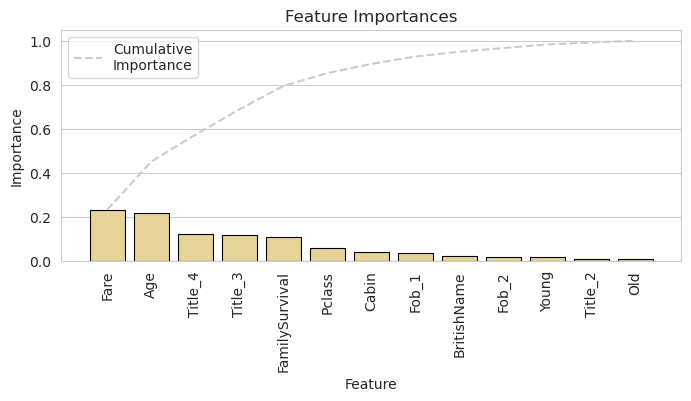

In [41]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(8, 3))

sns.barplot(x=importances.index, 
            y=importances.Importance, 
            edgecolor='black',
            linewidth=0.8,
            color=g_color, 
            ax=ax)

cumulative_line = ax.plot(importances.index, importances.CumImp, linestyle='--', color=d_color)

# Create a Line2D object for the dashed gray line in legend.
dashed_line = mlines.Line2D([], [], color=d_color, linestyle='--', label='Cumulative\nImportance')

ax.set_ylabel('Importance')
ax.set_title('Feature Importances')

# Include the dashed_line in the legend
plt.legend(handles=[dashed_line])

plt.xticks(rotation=90)

plt.show()

#### Observations:
- The **Fare** feature has the highest importance, accounting for 34.5% of the total importance.
- **Title_4** and **Title_3** are the next most important features, with importances of 15.9% and 14.1%, respectively.
- The cumulative importance of the top four features (**Fare**, **Title_4**, **Title_3**, and **FamilySurvival**) is approximately 77.7%, indicating that these features contribute significantly to the model's predictive power.
- All features appear to be useful. Even 1.4% from **Old** is not insignificant.

# 5 Modelling
Training and evaluating various machine learning models to find the best fit for the given problem.
## 5.1 Model exploration
Analyzing model performance and other characteristics to gain insights into each model's strengths and weaknesses.

In [42]:
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

MODELS = [
    # Linear Models
    LogisticRegressionCV(),
    PassiveAggressiveClassifier(),
    
    # Tree Models    
    DecisionTreeClassifier(),
    
    # SVM
    SVC(probability=True),
    LinearSVC(),
    
    # Nearest Neighbor
    KNeighborsClassifier(),
    
    # Navies Bayes
    BernoulliNB(),
    GaussianNB(),
    
    # Gaussian Processes
    GaussianProcessClassifier(),

    # Discriminant Analysis
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    
    # Ensemble
    AdaBoostClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),

    # LGBM
    LGBMClassifier(),
    
    # XGBoost
    XGBClassifier(),    
    
    # Catboost
    CatBoostClassifier(silent=True)
]

k_fold = StratifiedKFold(n_splits=5)

columns = ['Model Name', 'Train Accuracy Mean', 'Test Accuracy Mean', 'Test Accuracy STD * 3', 'Time', 'Parameters', 'Model']
models = pd.DataFrame(columns=columns)

row_index = 0
for ml in MODELS:
    model_name = ml.__class__.__name__
    models.loc[row_index, 'Model Name'] = model_name
    models.loc[row_index, 'Parameters'] = str(ml.get_params())
    
    cv_results = cross_validate(ml, X_train, y_train, n_jobs=4, cv=k_fold, return_train_score=True, return_estimator=True)

    models.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    models.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    models.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_score'].mean()
    models.loc[row_index, 'Test Accuracy STD * 3'] = cv_results['test_score'].std() * 3
    models.loc[row_index, 'Model'] = cv_results['estimator']
    
    row_index+=1

models.sort_values(by=['Test Accuracy Mean'], ascending=False, inplace=True)
models.reset_index(drop=True, inplace=True)
models

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Test Accuracy STD * 3,Time,Parameters,Model
0,CatBoostClassifier,0.912178,0.848459,0.07032,5.587078,{'silent': True},[<catboost.core.CatBoostClassifier object at 0...
1,GradientBoostingClassifier,0.90432,0.847335,0.066522,0.164316,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",[([DecisionTreeRegressor(criterion='friedman_m...
2,LogisticRegressionCV,0.856902,0.845113,0.083728,0.461233,"{'Cs': 10, 'class_weight': None, 'cv': None, '...","[LogisticRegressionCV(), LogisticRegressionCV(..."
3,LinearSVC,0.852692,0.845101,0.066543,0.023339,"{'C': 1.0, 'class_weight': None, 'dual': True,...","[LinearSVC(), LinearSVC(), LinearSVC(), Linear..."
4,LinearDiscriminantAnalysis,0.85157,0.841736,0.065473,0.009012,"{'covariance_estimator': None, 'n_components':...","[LinearDiscriminantAnalysis(), LinearDiscrimin..."
5,SVC,0.863073,0.840625,0.052946,0.188884,"{'C': 1.0, 'break_ties': False, 'cache_size': ...","[SVC(probability=True), SVC(probability=True),..."
6,AdaBoostClassifier,0.861112,0.839533,0.070547,0.135016,"{'algorithm': 'SAMME.R', 'base_estimator': Non...","[(DecisionTreeClassifier(max_depth=1, random_s..."
7,QuadraticDiscriminantAnalysis,0.845117,0.838365,0.072933,0.004228,"{'priors': None, 'reg_param': 0.0, 'store_cova...","[QuadraticDiscriminantAnalysis(), QuadraticDis..."
8,XGBClassifier,0.974747,0.838353,0.074654,1.117565,"{'objective': 'binary:logistic', 'use_label_en...","[XGBClassifier(base_score=0.5, booster='gbtree..."
9,LGBMClassifier,0.959315,0.837236,0.06083,0.180783,"{'boosting_type': 'gbdt', 'class_weight': None...","[LGBMClassifier(), LGBMClassifier(), LGBMClass..."


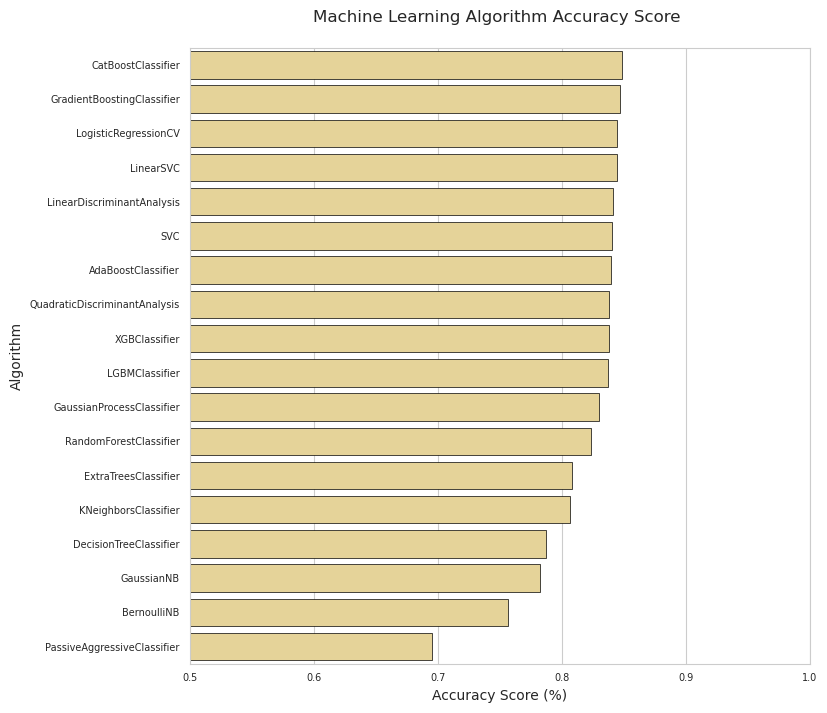

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(x='Test Accuracy Mean', 
            y='Model Name', 
            data=models, 
            edgecolor='black',
            linewidth=0.5,
            color=g_color)

plt.tick_params(labelsize=7)
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlim(0.5, 1)
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.show()

#### Observations:
- Some algorithms perform significantly better than others.
- We can see overfitting in the boosting algorithms and some simpler models performed surprisingly well.
- We are going to proceed with the light gradient boosting model as it can be trained quickly and can be configured to have excellent accuracy.


## 5.2 Bayseian optimization 
Instead of using a grid or random search for exploring the parameter space, we will employ Bayesian optimization, which intelligently samples the hyperparameters by constructing a probabilistic model based on the past evaluations. 

Bayesian optimization balances exploration and exploitation, enabling a more efficient search for optimal hyperparameter values.

This approach is a powerful technique that leads to better performing models with fewer evaluations needed.

### Bayseian optimization with Optuna

In [44]:
import optuna

def objective(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 128)
    learning_rate = trial.suggest_float("learning_rate", 1e-8, 1.0, log=True)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)

    classifier = LGBMClassifier(
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
    )
    
    # Perform 5 fold cross-validation
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(classifier, X_train, y_train, cv=k_fold, scoring='accuracy')

    # Compute the average score across all folds
    mean_score = np.mean(scores)

    return mean_score

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

In [45]:
best_params = study.best_params
best_score = study.best_value

print(f"Best hyperparameters: {best_params}")
print(f"Best average accuracy: {best_score}")

Best hyperparameters: {'num_leaves': 94, 'learning_rate': 0.09216816583254249, 'min_child_samples': 22, 'subsample': 0.8383390678616623, 'colsample_bytree': 0.6151585948636685, 'reg_alpha': 0.9513896064853592, 'reg_lambda': 1.1468643394337568}
Best average accuracy: 0.8563492561672211


## 5.3 Final model selection
Choosing the best-performing model then retraining it on the full dataset.

In [46]:
best_classifier = LGBMClassifier(**best_params)
best_classifier.fit(X_train, y_train)

test_df['Survived'] = best_classifier.predict(X_test).astype(int)
out_file = './LGBM_titanic_submission.csv'
test_df.to_csv(out_file,columns=['Survived'])